# DICE 2016R

This notebook compares DICE.jl to the `DICE2016R-091916ap.gms` GAMS file.

In [1]:
# For Solving #
using DICE;

# For Plotting #
using Plots;

# For Comparing with GAMS data
import JuMP;

## Base Price Scenario

The 2016R beta version has a base carbon price and an optimal carbon price scenario.

If you are interested in just the preset scenarios there is no reason to generate a configuration struct by calling `options(v2016R())`, since this is called internally and altered as needed if necessary.

Calling the solve function directly is all that's needed to obtain all results.

In [2]:
base = solve(BasePrice, v2016R())

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     6794
Number of nonzeros in inequality constraint Jacobian.:      297
Number of nonzeros in Lagrangian Hessian.............:     1597

Total number of variables............................:     2701
                     variables with only lower bounds:      900
                variables with lower and upper bounds:      300
                     variables with only upper bounds:      100
Total number of equality constraints.................:     2411
Total number of inequality constraints...............:       99
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       99

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

Base (current policy) carbon price scenario using v2016R beta.
A JuMP Model
Maximization problem with:
Variables: 2701
Objective function type: JuMP.VariableRef
`JuMP.VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 1200 constraints
`JuMP.VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 445 constraints
`JuMP.GenericAffExpr{Float64,JuMP.VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 1211 constraints
`JuMP.GenericQuadExpr{Float64,JuMP.VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 400 constraints
Nonlinear: 899 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: SolverName() attribute not implemented by the optimizer.
Names registered in the model: C, CCA, CCATOT, CEMUTOTPER, CPC, CPRICE, DAMAGES, E, Eind, FORC, I, K, MCABATE, Mᵤₚ, Mₐₜ, Mₗₒ, PERIODU, RI, S, Tₐₜ, Tₗₒ, UTILITY, Y, YGROSS, YNET, Λ, Ω, μ

The variable `base` is now a complete solution of type `DICENarrative`.

It contains all of the model parameters and information, as well as usable results.

In [3]:
fieldnames(typeof(base))

(:constants, :parameters, :model, :scenario, :version, :variables, :equations, :results)

Whilst the `results` are fairly comprehensive, you may wish to look at specific values of the model directly. Since most of these are in their raw state you will need to `import JuMP` to read them correctly.

---

Word of warning: if you `print(base.model)` in this notebook you're gonna have a bad time.
It's apparently too big to print or something.
The thread just locks up/spools forever.

There's a *limit output* notebook extension which can truncate things for you.
It seems to be necessary if you want to use notebooks which have actual output.

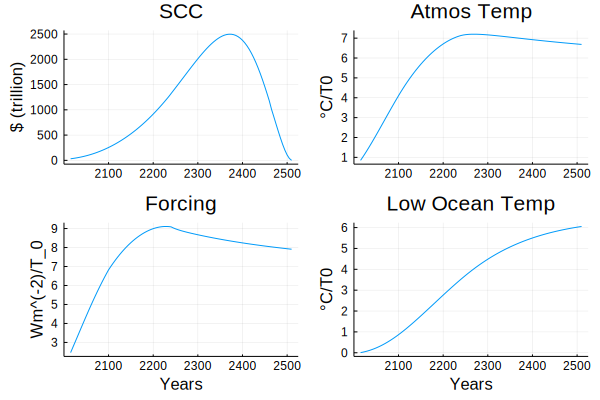

In [4]:
# Plot major outputs #
r = base.results;
a = plot(r.years,r.scc, ylabel="\$ (trillion)", title="SCC")
b = plot(r.years,r.Tₐₜ, ylabel="°C/T0", title="Atmos Temp")
c = plot(r.years,r.FORC, xlabel="Years", ylabel="Wm^(-2)/T_0", title="Forcing")
d = plot(r.years,r.Tₗₒ, xlabel="Years", ylabel="°C/T0", title="Low Ocean Temp")
plot(a,b,c,d,layout=(2,2),legend=false)

# Optimal Scenario

The optimal carbon price scenario is ran in a similar fashion.

In [5]:
opt = solve(OptimalPrice, v2016R())

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     6794
Number of nonzeros in inequality constraint Jacobian.:      297
Number of nonzeros in Lagrangian Hessian.............:     1597

Total number of variables............................:     2701
                     variables with only lower bounds:      900
                variables with lower and upper bounds:      300
                     variables with only upper bounds:      100
Total number of equality constraints.................:     2411
Total number of inequality constraints...............:       99
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       99

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

Optimal carbon price scenario using v2016R beta.
A JuMP Model
Maximization problem with:
Variables: 2701
Objective function type: JuMP.VariableRef
`JuMP.VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 1200 constraints
`JuMP.VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 400 constraints
`JuMP.GenericAffExpr{Float64,JuMP.VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 1211 constraints
`JuMP.GenericQuadExpr{Float64,JuMP.VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 400 constraints
Nonlinear: 899 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: SolverName() attribute not implemented by the optimizer.
Names registered in the model: C, CCA, CCATOT, CEMUTOTPER, CPC, CPRICE, DAMAGES, E, Eind, FORC, I, K, MCABATE, Mᵤₚ, Mₐₜ, Mₗₒ, PERIODU, RI, S, Tₐₜ, Tₗₒ, UTILITY, Y, YGROSS, YNET, Λ, Ω, μ

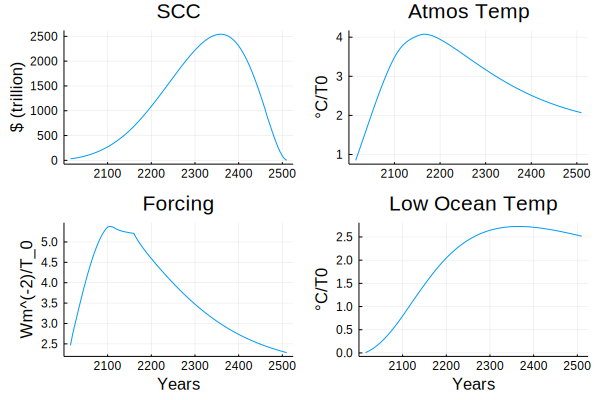

In [6]:
# Plot major outputs #
ro = opt.results;
a = plot(ro.years,ro.scc, ylabel="\$ (trillion)", title="SCC")
b = plot(ro.years,ro.Tₐₜ, ylabel="°C/T0", title="Atmos Temp")
c = plot(ro.years,ro.FORC, xlabel="Years", ylabel="Wm^(-2)/T_0", title="Forcing")
d = plot(ro.years,ro.Tₗₒ, xlabel="Years", ylabel="°C/T0", title="Low Ocean Temp")
plot(a,b,c,d,layout=(2,2),legend=false)

# Base Price Comparison

In [7]:
params = Dict{String,Array{Float64,1}}();
for line in eachline("../GAMS/d2016R_Base-results.txt")
    try
        key, val = split(line, ","; limit=2)
        k = Meta.parse(key)
        theRest = split(val, ",")
        if length(theRest) > 1
            # Just take Arrays for now
            params[strip(k)] = Meta.parse.(theRest);
        end
    catch
    end
end
# print(keys(params))

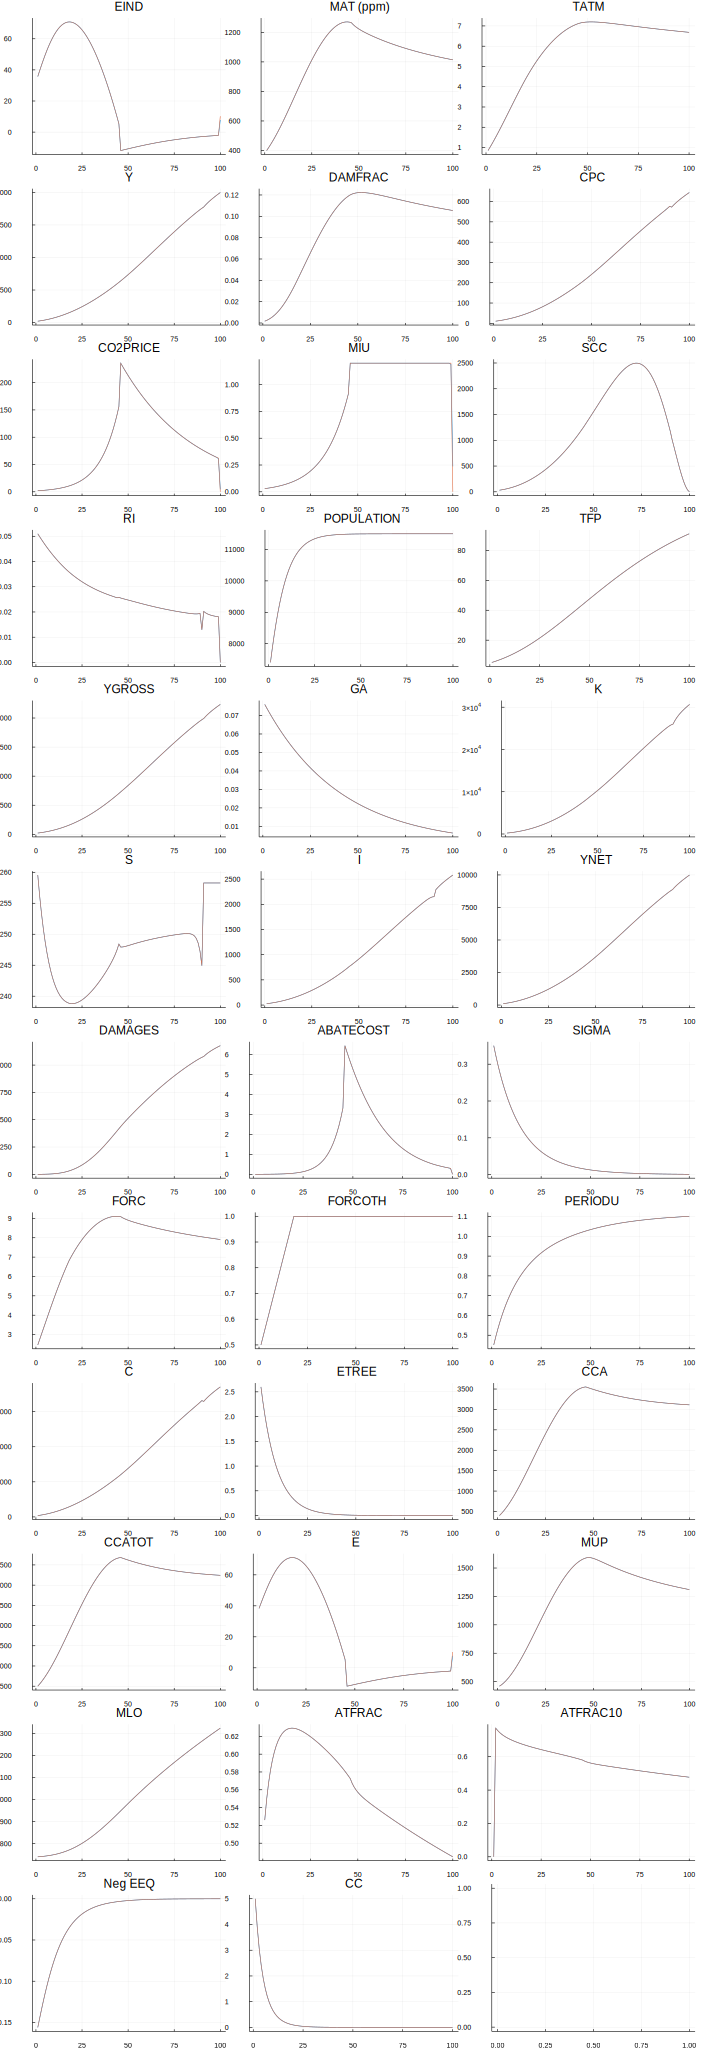

In [8]:
a = plot(base.results.Eind, title="EIND")
plot!(params["Industrial Emissions GTCO2 per year"])
b = plot(base.results.Mₐₜppm, title="MAT (ppm)")
plot!(params["Atmospheric concentration C (ppm)"])
c = plot(base.results.Tₐₜ, title="TATM")
plot!(params["Atmospheric Temperature"])
d = plot(base.results.Y, title="Y")
plot!(params["Output Net Net)"])
e = plot(base.results.Ω, title="DAMFRAC")
plot!(params["Climate Damages fraction output"])
f = plot(base.results.CPC, title="CPC")
plot!(params["Consumption Per Capita"])
g = plot(base.results.co2price, title="CO2PRICE")
plot!(params["Carbon Price (per t CO2)"])
h = plot(base.results.μ, title="MIU")
plot!(params["Emissions Control Rate"])
i = plot(base.results.scc, title="SCC")
plot!(params["Social cost of carbon"])
j = plot(base.results.RI, title="RI")
plot!(params["Interest Rate"])
k = plot(base.parameters.L, title="POPULATION")
plot!(params["Population"])
l = plot(base.parameters.A, title="TFP")
plot!(params["TFP"])
m = plot(base.results.YGROSS, title="YGROSS")
plot!(params["Output gross gross"])
n = plot(base.parameters.gₐ, title="GA")
plot!(params["Change tfp"])
o = plot(base.results.K, title="K")
plot!(params["Capital"])
p = plot(base.results.S, title="S")
plot!(params["s"])
q = plot(base.results.I, title="I")
plot!(params["I"])
r = plot(base.results.YNET, title="YNET")
plot!(params["Y gross net"])
s = plot(base.results.DAMAGES, title="DAMAGES")
plot!(params["damages"])
t = plot(base.results.Λ, title="ABATECOST")
plot!(params["abatement"])
u = plot(base.parameters.σ, title="SIGMA")
plot!(params["sigma"])
v = plot(base.results.FORC, title="FORC")
plot!(params["Forcings"])
w = plot(base.parameters.fₑₓ, title="FORCOTH")
plot!(params["Other Forcings"])
x = plot(base.results.PERIODU, title="PERIODU")
plot!(params["Period utilty"])
y = plot(base.results.C, title="C")
plot!(params["Consumption"])
z = plot(base.parameters.Etree, title="ETREE")
plot!(params["Land emissions"])
aa = plot(base.results.CCA, title="CCA")
plot!(params["Cumulative ind emissions"])
ab = plot(base.results.CCATOT, title="CCATOT")
plot!(params["Cumulative total emissions"])
ac = plot(base.results.E, title="E")
plot!(params["Total Emissions GTCO2 per year"])
ad = plot(base.results.Mᵤₚ, title="MUP")
plot!(params["Atmospheric concentrations upper"])
ae = plot(base.results.Mₗₒ, title="MLO")
plot!(params["Atmospheric concentrations lower"])
af = plot(base.results.atfrac, title="ATFRAC")
plot!(params["Atmospheric fraction since 1850"])
ag = plot(base.results.atfrac2010, title="ATFRAC10")
plot!(params["Atmospheric fraction since 2010"])
ah = plot(-JuMP.shadow_price.(base.equations.eeq), title="Neg EEQ")
plot!(params["eeq dual"])
ai = plot(JuMP.shadow_price.(base.equations.cc), title="CC")
plot!(params["cc dual"])
aj = plot([],[])
plot(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,aa,ab,ac,ad,ae,af,ag,ah,ai,aj,layout=(12,3),legend=false,label=["Julia" "GAMS"],size=(1200,3500))

CONOPT Utility = `4485.7434565264`

In [9]:
base.results.UTILITY

4485.743456111951

# Optimal Price Comparison

In [10]:
oparams = Dict{String,Array{Float64,1}}();
for line in eachline("../GAMS/d2016R_Optimal-results.txt")
    try
        key, val = split(line, ","; limit=2)
        k = Meta.parse(key)
        theRest = split(val, ",")
        if length(theRest) > 1
            # Just take Arrays for now
            oparams[strip(k)] = Meta.parse.(theRest);
        end
    catch
    end
end
# print(keys(oparams))

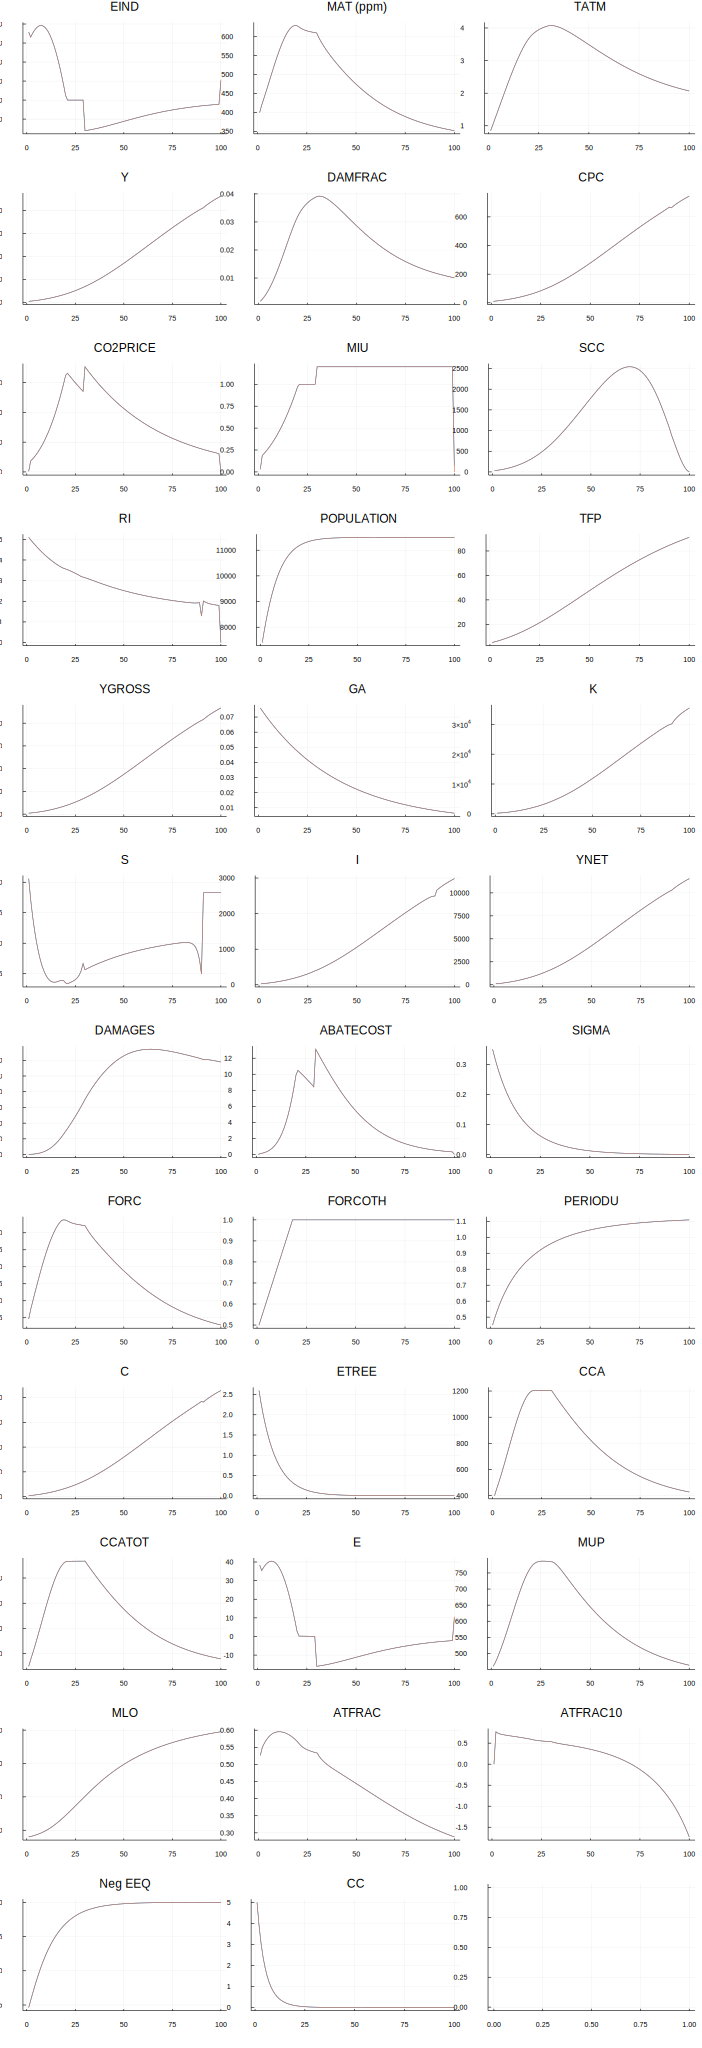

In [11]:
a = plot(opt.results.Eind, title="EIND")
plot!(oparams["Industrial Emissions GTCO2 per year"])
b = plot(opt.results.Mₐₜppm, title="MAT (ppm)")
plot!(oparams["Atmospheric concentration C (ppm)"])
c = plot(opt.results.Tₐₜ, title="TATM")
plot!(oparams["Atmospheric Temperature"])
d = plot(opt.results.Y, title="Y")
plot!(oparams["Output Net Net)"])
e = plot(opt.results.Ω, title="DAMFRAC")
plot!(oparams["Climate Damages fraction output"])
f = plot(opt.results.CPC, title="CPC")
plot!(oparams["Consumption Per Capita"])
g = plot(opt.results.co2price, title="CO2PRICE")
plot!(oparams["Carbon Price (per t CO2)"])
h = plot(opt.results.μ, title="MIU")
plot!(oparams["Emissions Control Rate"])
i = plot(opt.results.scc, title="SCC")
plot!(oparams["Social cost of carbon"])
j = plot(opt.results.RI, title="RI")
plot!(oparams["Interest Rate"])
k = plot(opt.parameters.L, title="POPULATION")
plot!(oparams["Population"])
l = plot(opt.parameters.A, title="TFP")
plot!(oparams["TFP"])
m = plot(opt.results.YGROSS, title="YGROSS")
plot!(oparams["Output gross gross"])
n = plot(opt.parameters.gₐ, title="GA")
plot!(oparams["Change tfp"])
o = plot(opt.results.K, title="K")
plot!(oparams["Capital"])
p = plot(opt.results.S, title="S")
plot!(oparams["s"])
q = plot(opt.results.I, title="I")
plot!(oparams["I"])
r = plot(opt.results.YNET, title="YNET")
plot!(oparams["Y gross net"])
s = plot(opt.results.DAMAGES, title="DAMAGES")
plot!(oparams["damages"])
t = plot(opt.results.Λ, title="ABATECOST")
plot!(oparams["abatement"])
u = plot(opt.parameters.σ, title="SIGMA")
plot!(oparams["sigma"])
v = plot(opt.results.FORC, title="FORC")
plot!(oparams["Forcings"])
w = plot(opt.parameters.fₑₓ, title="FORCOTH")
plot!(oparams["Other Forcings"])
x = plot(opt.results.PERIODU, title="PERIODU")
plot!(oparams["Period utilty"])
y = plot(opt.results.C, title="C")
plot!(oparams["Consumption"])
z = plot(opt.parameters.Etree, title="ETREE")
plot!(oparams["Land emissions"])
aa = plot(opt.results.CCA, title="CCA")
plot!(oparams["Cumulative ind emissions"])
ab = plot(opt.results.CCATOT, title="CCATOT")
plot!(oparams["Cumulative total emissions"])
ac = plot(opt.results.E, title="E")
plot!(oparams["Total Emissions GTCO2 per year"])
ad = plot(opt.results.Mᵤₚ, title="MUP")
plot!(oparams["Atmospheric concentrations upper"])
ae = plot(opt.results.Mₗₒ, title="MLO")
plot!(oparams["Atmospheric concentrations lower"])
af = plot(opt.results.atfrac, title="ATFRAC")
plot!(oparams["Atmospheric fraction since 1850"])
ag = plot(opt.results.atfrac2010, title="ATFRAC10")
plot!(oparams["Atmospheric fraction since 2010"])
ah = plot(-JuMP.shadow_price.(opt.equations.eeq), title="Neg EEQ")
plot!(oparams["eeq dual"])
ai = plot(JuMP.shadow_price.(opt.equations.cc), title="CC")
plot!(oparams["cc dual"])
aj = plot([],[])
plot(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,aa,ab,ac,ad,ae,af,ag,ah,ai,aj,layout=(12,3),legend=false,label=["Julia" "GAMS"],size=(1200,3500))

CONOPT Utility = `4517.3146811528`

In [12]:
opt.results.UTILITY

4517.314680934477